Todo: Need to find common negative/positive words in headlines (based on price changes) and update vader sentiment lexicons.
train RF on headline_clean to predict price changes: binary classification (0 if price change is -ve, 1 if price change is +ve)

In [1]:
from pystock.helper_functions import load_news_df, mergeFiles2df
from pystock import constants
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import requests
from tqdm import tqdm
import glob

# Get historical news data

In [2]:
def get_historical_news(ticker, date_from, date_to, outdir, website='finnhub'):
    data = {"symbol": ticker,
            "from": date_from,
            "to": date_to,
            "token": constants.FINNHUB_KEY} 
    
    if website == 'finnhub':
        response = requests.get('https://finnhub.io/api/v1/company-news', data)
    df = pd.DataFrame.from_dict(response.json()).drop(['category', 'id', 'image', 'url'], axis=1)
    df['datetime'] = pd.to_datetime(df['datetime'],unit='s')
    df = df.set_index('datetime')
    
    # actual date_from (rate limited by 500 responses/ API call)
    date_from = str(df.index.min().date())
    
    file = open(f'{outdir}/{ticker}_{date_from}_{date_to}_{website}.pkl', 'wb')
    pickle.dump(df, file)
    file.close()
    return df

In [5]:
def get_historical_news_recursive(ticker, dates, outdir):
    # start with 1 year span, then adjust date_to to earliest date in df
    # stop after 60 API calls (rate limited)
    # Adjust the end parameter in dates variable to last_date
    last_date = None
    for i in tqdm(range(60)):
        if i == 0:
            df = get_historical_news(ticker, date_from=dates[0], date_to=dates[-1], outdir=outdir)
        else:
            last_date = str(df.index.min().date())
            df = get_historical_news(ticker, date_from=dates[0], date_to=last_date, outdir=outdir)

        if last_date == dates[0] or str(df.index.min().date()) == last_date:
            break
    print(str(df.index.min().date()))
    

In [8]:
ticker = 'CCIV'
dates = pd.date_range(start='2020-03-20', end='2021-03-17').astype(str).tolist()
outdir = 'data/parsed_data/'
get_historical_news_recursive(ticker, dates, outdir)

 18%|███████████████                                                                   | 11/60 [00:15<01:07,  1.39s/it]


KeyboardInterrupt: 

# Merge news data

In [13]:
ticker = 'CCIV'
indir = f'data/parsed_data/{ticker}*'
files = glob.glob(indir)

In [10]:
df_merge = mergeFiles2df(files, load_news_df)

Creating dataset:

1/2
data/parsed_data\CCIV_2020-09-24_2020-09-24_finnhub.pkl
_____________
2/2
data/parsed_data\CCIV_2020-09-24_2021-03-17_finnhub.pkl
_____________
Dataset created!


In [11]:
df_merge.drop_duplicates(inplace=True)

In [12]:
df_merge

,headline,ticker,source,summary
datetime,,,,
2020-09-24 14:38:00,Churchill Capital Launches Fifth SPAC,CCIV,Benzinga,"Michael Klein, one of the prominent names in t..."
2020-09-30 00:00:00,"Kevin O'Leary Shares SPAC Picks, Impressions",CCIV,benzinga,"Entrepreneur and ""Shark Tank"" judge Kevin O’Le..."
2020-10-02 16:29:48,"After Hours Most Active for Oct 2, 2020 : SBH...",CCIV,Nasdaq,The NASDAQ 100 After Hours Indicator is up 12....
2020-10-02 19:59:59,"After Hours Most Active for Oct 2, 2020 : SBH...",CCIV,Nasdaq,The NASDAQ 100 After Hours Indicator is down -...
2020-10-12 00:00:00,"Q3 The Busiest Since 2014 For IPOs, Led By Uni...",CCIV,benzinga,The third quarter saw 86 companies go public v...
...,...,...,...,...
2021-03-11 11:59:28,Jaws Spitfire Acquisition Corporation: SpaceX ...,CCIV,seekingalpha.com,
2021-03-11 12:06:42,Buckle In for a Wild Ride With Churchill Capit...,CCIV,Nasdaq,"InvestorPlace - Stock Market News, Stock Advic..."
2021-03-12 01:00:49,"While You Slept, Tesla Ushered In The Golden A...",CCIV,seekingalpha.com,Tesla's rapid ascent has helped usher in a new...


In [14]:
df_merge.to_csv(f'data/parsed_data/{ticker}_{df_merge.index.min().date()}_{df_merge.index.max().date()}_finnhub.csv')

# News and price analysis

In [2]:
import pickle

def load_var(filename):
    with open(filename, 'rb') as f:
        var = pickle.load(f)
    return var


In [3]:
df = load_var('data/data_2020-04-01_2021-03-26.pkl')

In [4]:
df

,headline,related,source,summary,change_1h,change_4h
time,,,,,,
2021-03-17 16:43:00,Carnival Corp. stock outperforms market on str...,CCL,MarketWatch,Shares of Carnival Corp. rallied 2.41% to $28....,0.001385,0.022507
2021-03-17 10:43:31,Reasons To Avoid Carnival Stock At Current Levels,CCL,seekingalpha.com,Cruise industry recovery to pre-COVID levels i...,0.018648,0.029586
2021-03-17 09:22:00,"Amid vaccine hurdles, EU battles to save summe...",CCL,MarketWatch,"A ""digital green certificate” will be a proof ...",0.011445,0.007092
2021-03-17 05:30:00,American Airlines Joins Debt-Market Behemoths,CCL,DowJones,Recent $10 billion financing transfers much of...,-0.009890,-0.009890
2021-03-16 16:44:00,"Carnival Corp. stock falls Tuesday, underperfo...",CCL,MarketWatch,Shares of Carnival Corp. slipped 5.17% to $28....,-0.000353,-0.009890
...,...,...,...,...,...,...
2020-09-17 06:33:00,Snowflake Will Have to Run Extra Hot,SNOW,DowJones,Data warehousing provider’s soaring IPO puts i...,-0.053278,-0.053278
2020-09-17 05:04:00,62 Biggest Movers From Yesterday,SNOW,Benzinga,Gainers\n\nSnowflake Inc. (NYSE: SNOW) shares ...,-0.053278,-0.053278
2020-09-17 02:32:00,"Sumo Logic Prices IPO Above Indicated Range, I...",SNOW,Benzinga,Sumo Logic Inc (NASDAQ: SUMO) priced its initi...,-0.053278,-0.053278


In [5]:
import pandas as pd             # handle data
import matplotlib.pyplot as plt # plotting
import gc                       # free up ram
import re                       # text preprocessing
import nltk                     # NLP
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer # sentiment analysis
from pprint import pprint       # pretty print
import numpy as np              # numbers 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # Word cloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

In [6]:
def run_process_text(df, col):
    """Drop duplicates and clean tweets"""
    df = df.drop_duplicates()  # Drop duplicates
    df[col] = df[col].apply(process_text)   # Process text
    return df
    
def process_text(text):
    """ Clean input tweets """
    hashtags = re.compile(r"^#\S+|\s#\S+")
    mentions = re.compile(r"^@\S+|\s@\S+")
    andSymbol = re.compile(r"^&\S+|\s&\S+")
    urls = re.compile(r"https?://\S+")
    control_char = re.compile(r"[\n\r\t]")
    text = hashtags.sub(' hashtag', text)
    text = andSymbol.sub('', text)
    text = mentions.sub(' entity', text)
    text = urls.sub(' website ', text)
    text = control_char.sub('', text)
    text = text.encode('ascii', 'ignore').decode('ascii') # remove emoji
    return text.strip().lower() 

In [7]:
df = run_process_text(df, 'headline')

In [8]:
df

,headline,related,source,summary,change_1h,change_4h
time,,,,,,
2021-03-17 16:43:00,carnival corp. stock outperforms market on str...,CCL,MarketWatch,Shares of Carnival Corp. rallied 2.41% to $28....,0.001385,0.022507
2021-03-17 10:43:31,reasons to avoid carnival stock at current levels,CCL,seekingalpha.com,Cruise industry recovery to pre-COVID levels i...,0.018648,0.029586
2021-03-17 09:22:00,"amid vaccine hurdles, eu battles to save summe...",CCL,MarketWatch,"A ""digital green certificate” will be a proof ...",0.011445,0.007092
2021-03-17 05:30:00,american airlines joins debt-market behemoths,CCL,DowJones,Recent $10 billion financing transfers much of...,-0.009890,-0.009890
2021-03-16 16:44:00,"carnival corp. stock falls tuesday, underperfo...",CCL,MarketWatch,Shares of Carnival Corp. slipped 5.17% to $28....,-0.000353,-0.009890
...,...,...,...,...,...,...
2020-09-17 06:33:00,snowflake will have to run extra hot,SNOW,DowJones,Data warehousing provider’s soaring IPO puts i...,-0.053278,-0.053278
2020-09-17 05:04:00,62 biggest movers from yesterday,SNOW,Benzinga,Gainers\n\nSnowflake Inc. (NYSE: SNOW) shares ...,-0.053278,-0.053278
2020-09-17 02:32:00,"sumo logic prices ipo above indicated range, i...",SNOW,Benzinga,Sumo Logic Inc (NASDAQ: SUMO) priced its initi...,-0.053278,-0.053278


In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import spacy
nlp = spacy.load("en_core_web_sm")

def pipelinize(function, active=True):
    # Adapted from https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

def spacy_tokenizer_lemmatizer(text):
    doc = nlp(text)
    lemma_list = []
    for token in doc:
        if token.is_stop is False:
            lemma_list.append(token.lemma_)
    
    out = " ".join(lemma_list)
    return(preprocessor_final(out))


def preprocessor_final(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', ' ', text)
        text = re.sub('[\W]+', ' ', text.lower())
        return text
    
    if isinstance((text), (list)):
        return_list = []

        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            
            if len(temp_text) != 0:
                return_list.append(temp_text)
                
        return(return_list)
    else:
        pass


In [117]:
%%time
sample_text = df_sample['headline'].iloc[4]
print(sample_text)
df['headline_clean'] = df.headline.apply(spacy_tokenizer_lemmatizer)

cruise stocks get upgraded by macquarie, because covids worst is in the past
Wall time: 3min 24s


In [121]:
df[['headline','headline_clean']]

,headline,headline_clean
time,,
2021-03-17 16:43:00,carnival corp. stock outperforms market on str...,carnival corp stock outperform market strong t...
2021-03-17 10:43:31,reasons to avoid carnival stock at current levels,reason avoid carnival stock current level
2021-03-17 09:22:00,"amid vaccine hurdles, eu battles to save summe...",amid vaccine hurdle eu battle save summer vaca...
2021-03-17 05:30:00,american airlines joins debt-market behemoths,american airline join debt market behemoth
2021-03-16 16:44:00,"carnival corp. stock falls tuesday, underperfo...",carnival corp stock fall tuesday underperform ...
...,...,...
2020-09-17 06:33:00,snowflake will have to run extra hot,snowflake run extra hot
2020-09-17 05:04:00,62 biggest movers from yesterday,62 big mover yesterday
2020-09-17 02:32:00,"sumo logic prices ipo above indicated range, i...",sumo logic price ipo indicate range software s...


## Sentiment analysis

In [141]:
def run_sentimentLabel(df, col):
    """ 
    Add sentiment label and scores to columns in dataframe.
    Ref: https://stackoverflow.com/questions/16236684/apply-pandas-function-to-column-to-create-multiple-new-columns#
    """

    columns = ['sentiment', 'sentiment_scores']
    temp = list(zip(*df[col].map(sentimentLabel))); 
    for i, c in enumerate(columns): 
        df[c] = temp[i]
    print('Sentiment analysis complete.')
    return df
        
def sentimentLabel(text, new_words={}):
    """ 
    Determine sentiment of a tweet: -1 negative, 0 neutral, 1 positive.
        In docs: https://github.com/cjhutto/vaderSentiment#about-the-scoring
        positive sentiment: compound score >= 0.05
        neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
        negative sentiment: compound score <= -0.05
        If you want to be more selective, increase threshold.
    """
    sia = SentimentIntensityAnalyzer() 
    
    if new_words:
        sia.lexicon.update(new_words)
        
    sentimentScores = sia.polarity_scores(text) 
    score = sentimentScores['compound']

    if score<=-SENTIMENT_THRESHOLD:       # negative
        return -1, sentimentScores
    elif score>=SENTIMENT_THRESHOLD:      # positive-words
        return 1, sentimentScores
    else:                                 # neutral
        return 0, sentimentScores     


In [10]:
SENTIMENT_THRESHOLD = 0.1

In [24]:
%%time 
df_sentiment = df.copy()
df_sentiment = run_sentimentLabel(df_sentiment, 'headline_clean')

Sentiment analysis complete.
Wall time: 4min 45s


In [31]:
def exampleBySentiment(df, n, col):
    """Return n examples from each sentiment label."""
    print(f'{n} example tweets from each topic: ')
    samples = {}
    for i, s in enumerate(df['sentiment'].unique()):
        samples[s] = df.query("sentiment==@s").sample(n)[col].to_list()
    pprint(samples)
    return samples

In [32]:
examples = exampleBySentiment(df_sentiment, 2, 'headline')

2 example tweets from each topic: 
{-1: ["dow jones futures: after worst week since march, don't feed the bears! "
      "here's what to do now",
      'why apple might lose the us governments war on google'],
 0: ['82 biggest movers from yesterday',
     'dow slips friday, nasdaq logs back-to-back declines amid rising '
     'china-u.s. tensions and languishing fiscal stimulus'],
 1: ['miller value partners opportunity equity 2q 2020 letter',
     '6 easy ways to clean & protect suede shoes']}


In [33]:
df_sentiment


,headline,related,source,summary,change_1h,change_4h,sentiment,sentiment_scores
time,,,,,,,,
2021-03-17 16:43:00,carnival corp. stock outperforms market on str...,CCL,MarketWatch,Shares of Carnival Corp. rallied 2.41% to $28....,0.001385,0.022507,1,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp..."
2021-03-17 10:43:31,reasons to avoid carnival stock at current levels,CCL,seekingalpha.com,Cruise industry recovery to pre-COVID levels i...,0.018648,0.029586,0,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp..."
2021-03-17 09:22:00,"amid vaccine hurdles, eu battles to save summe...",CCL,MarketWatch,"A ""digital green certificate” will be a proof ...",0.011445,0.007092,0,"{'neg': 0.155, 'neu': 0.655, 'pos': 0.19, 'com..."
2021-03-17 05:30:00,american airlines joins debt-market behemoths,CCL,DowJones,Recent $10 billion financing transfers much of...,-0.009890,-0.009890,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2021-03-16 16:44:00,"carnival corp. stock falls tuesday, underperfo...",CCL,MarketWatch,Shares of Carnival Corp. slipped 5.17% to $28....,-0.000353,-0.009890,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...,...
2020-09-17 06:33:00,snowflake will have to run extra hot,SNOW,DowJones,Data warehousing provider’s soaring IPO puts i...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2020-09-17 05:04:00,62 biggest movers from yesterday,SNOW,Benzinga,Gainers\n\nSnowflake Inc. (NYSE: SNOW) shares ...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2020-09-17 02:32:00,"sumo logic prices ipo above indicated range, i...",SNOW,Benzinga,Sumo Logic Inc (NASDAQ: SUMO) priced its initi...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [123]:
df.iloc[4].headline_clean, sentimentLabel(df.iloc[4].headline_clean)

('carnival corp stock fall tuesday underperform market',
 (0, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}))

Vocabulary is limited for Vader and does not register words like 'fall' and 'underperforms' as negative words. Just get all neutral --> useless.

Need to add new vocabulary to vader sentiment analysis.

In [146]:
new_words = {
    'fall': -1.0,
    'underperform': -1.4,
}

In [147]:
%%time
df.iloc[4].headline_clean, sentimentLabel(df.iloc[4].headline_clean, new_words)

Wall time: 11.1 ms


('carnival corp stock fall tuesday underperform market',
 (-1, {'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.5267}))

## Changing compound score threshold for sentiment classification

In [38]:
def change_sentiment(compound_score, threshold):
    if compound_score >= threshold:
        return 1
    elif compound_score <= -threshold:
        return -1
    else:
        return 0

def test_threshold(df, threshold):
    sentiment_score_threshold = threshold
    df.sentiment = df.sentiment_scores.apply(lambda x: change_sentiment(x['compound'], sentiment_score_threshold))
    return df

In [39]:
df_sentiment = test_threshold(df_sentiment, 0.1);


In [40]:
df_sentiment

,headline,related,source,summary,change_1h,change_4h,sentiment,sentiment_scores
time,,,,,,,,
2021-03-17 16:43:00,carnival corp. stock outperforms market on str...,CCL,MarketWatch,Shares of Carnival Corp. rallied 2.41% to $28....,0.001385,0.022507,1,"{'neg': 0.0, 'neu': 0.708, 'pos': 0.292, 'comp..."
2021-03-17 10:43:31,reasons to avoid carnival stock at current levels,CCL,seekingalpha.com,Cruise industry recovery to pre-COVID levels i...,0.018648,0.029586,-1,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp..."
2021-03-17 09:22:00,"amid vaccine hurdles, eu battles to save summe...",CCL,MarketWatch,"A ""digital green certificate” will be a proof ...",0.011445,0.007092,1,"{'neg': 0.155, 'neu': 0.655, 'pos': 0.19, 'com..."
2021-03-17 05:30:00,american airlines joins debt-market behemoths,CCL,DowJones,Recent $10 billion financing transfers much of...,-0.009890,-0.009890,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2021-03-16 16:44:00,"carnival corp. stock falls tuesday, underperfo...",CCL,MarketWatch,Shares of Carnival Corp. slipped 5.17% to $28....,-0.000353,-0.009890,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
...,...,...,...,...,...,...,...,...
2020-09-17 06:33:00,snowflake will have to run extra hot,SNOW,DowJones,Data warehousing provider’s soaring IPO puts i...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2020-09-17 05:04:00,62 biggest movers from yesterday,SNOW,Benzinga,Gainers\n\nSnowflake Inc. (NYSE: SNOW) shares ...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2020-09-17 02:32:00,"sumo logic prices ipo above indicated range, i...",SNOW,Benzinga,Sumo Logic Inc (NASDAQ: SUMO) priced its initi...,-0.053278,-0.053278,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


## Wordcloud

In [36]:
def genWordCloud(text_series, words_to_remove=None, save=False):
    """ 
    Create word cloud given input text series.

    Common stop words:
    ["stop stop"]
    ["facemasks","facemask","face masks","mask",
                             "face covering", "facecovering","face",
                             "people","today","wearing", "mandatory mandatory",
                             "mandatory", "protect protect"]
    #['vaccine','vaccines','vaccination','will']
    #['test', 'trace', 'testandtrace']
    """
    all_text = " ".join(text_series.astype(str))

    #for word in topic_words_to_remove:
    #    all_text = all_text.replace(word, "")

    stop_words = list(STOPWORDS.union(set(stopwords.words('english')))) + words_to_remove

    wordcloud = WordCloud( max_words=200, 
                            background_color="white",
                            width=1600, height=800,
                            stopwords = stop_words,
                            min_word_length = 3,).generate(all_text)
    plt.figure( figsize=(10,8), facecolor='w')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    if save:
        plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')
    return wordcloud




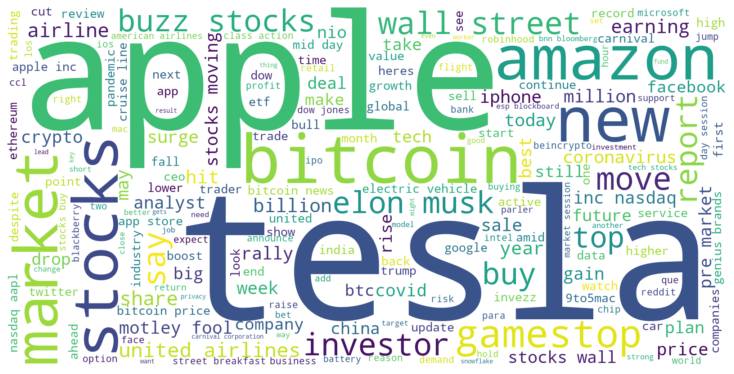

In [37]:
WORDS_TO_REMOVE = ["stock"]
df_sample = df[(df['change_1h']<0) & (df['change_4h']<0)]
wc = genWordCloud(df_sample['headline'], WORDS_TO_REMOVE)